In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import random
from collections import deque
import gymnasium as gym
import ipywidgets as widgets
from IPython.display import display, clear_output

from controllers import PIController
from controllers import MPCController # Group1: Copied this from pmsm_control_solution.ipynb
from environment import EnvPMSM
from utils import *
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Register gym environment
gym.register(
    id="EnvPMSM",
    entry_point=EnvPMSM,
)

figsize = (10, 6)

# Environment
In order to define this representation to work for any controller, the system is defined by using a Gymnasium (from Farama Foundation) environment template with the following class methods:

- \_\_init\_\_: Parameter initialization and definition of action and observation space.
- step: Single step for a discrete-time system representation.
- reset: Initial conditions for simulation for each episode.

The simulation sampling frequency is $10$ [kHz], the simulation consists of $200$ steps, the current is limited to $200$ [A], the DC-bus voltage is $1200$ [V], and the maximum voltage magnitude is limited by a sinusoidal pulse width modulation (SPWM) approach $V_{DC}/2 = 600$ [V].

In [ ]:
sys_params = {
    "dt": 1 / 10e3,             # Simulation step time [s]
    "r": 29.0808e-3,            # Phase Stator Resistance [Ohm]
    "ld": 0.91e-3,              # D-axis Inductance [H]
    "lq": 1.17e-3,              # Q-axis Inductance [H]
    "lambda_PM": 0.172312604,   # Flux-linkage due to permanent magnets [Wb]
    "we": 50*2*np.pi,           # Nominal speed [rad/s]
    "vdc": 1200,                # DC bus voltage [V]
    "sim_steps": 200,           # Simulation steps
    "i_max": 200,               # Maximum current [A]
    # Group1: Removed id_ref and iq_ref - they are now automatically calculated from torque_ref in environment.py
    # "id_ref": -10.0,          # Reference d-axis current [A]
    # "iq_ref": 100.0,          # Reference q-axis current [A]
    
    # Group1: Added the following parameters
    "p": 4,                     # Number of pole pairs
    "torque_max": 200,          # Maximum torque [Nm]
    "torque_ref": 150           # Reference torque [Nm]
}
sim_plot_steps = 20             # Simulation plot steps

Here we create two environments where in of them we can measure the output without noise, while the other one includes output measurement noise

In [3]:
env       = gym.make("EnvPMSM", sys_params=sys_params, meas_noise = False)
env_noisy = gym.make("EnvPMSM", sys_params=sys_params, meas_noise = True)

Initialize metrics class to compare the implementations later

In [4]:
# Group1: OLD
# Initialize metrics from utils.py
# metrics = Metrics(np.array([sys_params["id_ref"], sys_params["iq_ref"]]), sys_params["dt"])

# Group1: NEW
metrics = Metrics(torque_ref=sys_params["torque_ref"], dt=sys_params["dt"])


## Actor-Critic Network

### Actor

The **Actor** is a neural network that decides **which action to take** given the current state.

- **Input:** Current state $s_t$  
- **Output:** Action $a_t$ (continuous values)  
- **Goal:** Learn a policy $\pi(s_t)$ that **maximizes expected future reward**.  

**How it works:**  
1. The Actor proposes actions based on the current state.  
2. During training, it is updated to maximize the Q-value predicted by the Critic for the chosen action.  

In short, the Actor decides “what to do” in each state.

Here an Actor Network is initialized to then utilize in the DDPG implementation. The input size depends on the observation space shape, while the output size depends on the actions shape
<div style="text-align: center">
  <img src="./images/Actor_Network_1.png" alt="Actor Network" />
</div>

In [5]:
class ActorNetwork(nn.Module):
    def __init__(self, observation_space, action_space):
        super().__init__()

        # self.network = nn.Sequential(
        #     nn.Linear(np.prod(observation_space.shape),  256),
        #     nn.ReLU(),
        #     nn.Linear(256, 256),
        #     nn.ReLU(),
        #     nn.Linear(256, np.prod(action_space.shape)),
        #     nn.Tanh()
        # )

        # Group1: Instead of 2, we use 3 hidden layers with decreasing number of neurons
        self.network = nn.Sequential(
            nn.Linear(np.prod(observation_space.shape),  256),  # Input → 1st hidden (256)
            nn.ReLU(),
            nn.Linear(256, 128),                                # 1st hidden → 2nd hidden (128)
            nn.ReLU(),
            nn.Linear(128, 64),                                 # 2nd hidden → 3rd hidden (64)
            nn.ReLU(),
            nn.Linear(64, np.prod(action_space.shape)),         # 3rd hidden → Output (Action)
            nn.Tanh()
        )

        self.register_buffer(
            "action_scale", torch.tensor((action_space.high - action_space.low) / 2, dtype=torch.float32)
        )
        self.register_buffer(
            "action_bias", torch.tensor((action_space.high + action_space.low) / 2, dtype=torch.float32)
        )
        
    def forward(self, observation):
        action = self.network(observation)
        return action * self.action_scale + self.action_bias

### Critic
The **Critic** is a neural network that evaluates **how good an action is** in a given state.

- **Input:** State $s_t$ and action $a_t$  
- **Output:** Q-value $Q(s_t, a_t)$ (expected cumulative reward)  
- **Goal:** Estimate the expected reward of the Actor's actions accurately.  

**How it works:**  
1. The Critic receives a state-action pair.  
2. It predicts the expected future reward (Q-value).  
3. During training, the Critic is updated to minimize the difference between predicted Q-values and target Q-values (using Bellman equation).  

In short, the Critic evaluates “how good is the action taken by the Actor”.

This Critic Network is initialized to then utilize in the DDPG implementation. The input size depends on the observation + actions space shape, while the output size is a single value.
<div style="text-align: center">
  <img src="./images/Critic_Network_1.png" alt="Critic Network" />
</div>

In [6]:
class CriticNetwork(nn.Module):
    def __init__(self, observation_space, action_space):
        super().__init__()

        # self.network = nn.Sequential(
        #     nn.Linear(np.prod(observation_space.shape) + np.prod(action_space.shape),  256),
        #     nn.ReLU(),
        #     nn.Linear(256, 256),
        #     nn.ReLU(),
        #     nn.Linear(256, 1)
        # )

        # Group1: Again, instead of 2, we use 3 hidden layers with decreasing number of neurons
        self.network = nn.Sequential(
            nn.Linear(np.prod(observation_space.shape) + np.prod(action_space.shape),  256), # Input → 1st hidden (256)
            nn.ReLU(),
            nn.Linear(256, 128), # 1st hidden → 2nd hidden (128)
            nn.ReLU(),
            nn.Linear(128, 64), # 2nd hidden → 3rd hidden (64)
            nn.ReLU(),
            nn.Linear(64, 1) # 3rd hidden → Output (Q-value)
        )

        
    def forward(self, observation, action):
        return self.network(torch.cat([observation, action], dim=1))

### Replay Buffer in DDPG

The **replay buffer** is a memory that stores the agent's experiences as:

$$
(s_t, a_t, r_t, s_{t+1})
$$

where:  
- $s_t$ = current state  
- $a_t$ = action taken  
- $r_t$ = reward received  
- $s_{t+1}$ = next state  

**Why we use it:**
- **Break correlations:** Consecutive experiences are correlated. Random sampling helps the networks learn better.  
- **Reuse data:** Each experience can be used multiple times, improving efficiency.

**How it works in DDPG:**  
1. Store every experience in the buffer.  
2. Sample random mini-batches from the buffer to train the actor and critic.  
3. Update networks using these samples.

**Key parameters:**  
- **Buffer size:** Maximum number of stored experiences. Older ones are removed.  
- **Batch size:** Number of samples per training step.

The replay buffer helps DDPG learn more stably and efficiently.



In [7]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, transition):
        state, action, reward, next_state, terminated, truncated = transition
        done = terminated or truncated
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        observations, actions, rewards, next_observations, terminations = \
            zip(*random.sample(self.buffer, batch_size))
        return observations, actions, rewards, next_observations, terminations
    
    def __len__(self):
        return len(self.buffer)

### Ornstein–Uhlenbeck Noise

In DDPG, actions are continuous, so the agent needs **smooth and correlated noise** to explore effectively.  The **Ornstein–Uhlenbeck (OU) noise** process is commonly used for this purpose. Instead of adding random, uncorrelated noise (like Gaussian noise), OU noise produces **temporally correlated** values. This makes the exploration more natural for systems with **momentum or inertia**, such as motors or robotic joints.


**[Mathematical form](https://www.quantstart.com/articles/ornstein-uhlenbeck-simulation-with-python/):**

$$
x_{t+1} = x_t + \theta (\mu - x_t) \Delta t + \sigma \sqrt{\Delta t} \, \mathcal{N}(0, 1)
$$

where:  
- $x_t$: current noise value  
- $\mu$: mean value (usually 0)  
- $\theta$: rate of mean reversion (how fast it returns to $\mu$)  
- $\sigma$: volatility (how strong the noise is)  
- $\mathcal{N}(0, 1)$: standard Gaussian noise  

**How it’s used in DDPG:**  
1. The Actor outputs a deterministic action $a_t = \pi(s_t)$.  
2. OU noise is added for exploration:  
   $$
   a_t' = a_t + \text{OU}(t)
   $$
3. The noisy action $a_t'$ is applied to the environment.  

**Why it helps:**  
- Encourages **smooth exploration** instead of abrupt random jumps.  
- Matches well with **physical control systems** that evolve continuously.  
- Prevents unstable or unrealistic control signals during training.

In short, Ornstein–Uhlenbeck noise helps DDPG explore smoothly in continuous control tasks by generating time-correlated noise.


In [8]:
class OrnsteinUhlenbeckNoise:
    "OU noise generator class, used to add OU noise to actions."
    def __init__(self, size: int, dt: float, mu=0.0, sigma=0.1, theta=0.15):
        self.dt = dt
        self.mu = mu * torch.ones(size)
        self.sigma = sigma
        self.theta = theta
        self.size = size
        self.reset()
        
    def reset(self):
        "Resets noise to mean."
        self.state = self.mu.clone()
        
    def sample(self):
        "Returns next value generated in process."
        dx = self.theta * (self.mu - self.state) * self.dt + self.sigma * np.sqrt(self.dt) * torch.randn(self.size)
        self.state += dx
        return self.state.clone()

### Deep Deterministic Policy Gradient (DDPG)

This implementation of **Deep Deterministic Policy Gradient (DDPG)** follows the standard Actor–Critic structure for continuous control.  
The class initializes all components needed for training: networks, replay buffer, noise process, optimizers, and target networks.


### Main Components in This Implementation

#### **1. Actor and Target Actor**
- The **Actor** maps observations to continuous actions.  
- The **Target Actor** is a slowly updated copy used for stable target computation.  
- Initialization:
  - Both networks are created.
  - `soft_update(..., tau=1.0)` copies the Actor into the Target Actor exactly.
- Optimizer: `Adam` with learning rate `config.lr`.

#### **2. Critic and Target Critic**
- The **Critic** estimates the Q-value $Q(s, a)$.  
- The **Target Critic** is a smoothed copy used to compute stable target Q-values.  
- Both networks are initialized and synced just like the Actor.

#### **3. Replay Buffer**
- Stores experience tuples:  
  $$
  (s_t, a_t, r_t, s_{t+1}, \text{terminated}, \text{truncated})
  $$
- Allows uniform random sampling of batches for training.

#### **4. Ornstein–Uhlenbeck Noise**
- Used during training to generate **smooth exploration noise** added to the Actor output.  
- The noise matches the dimensionality of the action space:
  ```python
  size = np.prod(action_space.shape)


In [9]:
class DDPG:
    def __init__(self, env_with_noise=False):
        config = DDPGConfig()
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        
        # Initialize environment
        self.env = env if not env_with_noise else env_noisy
        
        # Get observation and action space
        observation_space, action_space = self.env.observation_space, self.env.action_space
        
        # Initialize Actor and Target Actor
        self.actor = ActorNetwork(observation_space, action_space).to(self.device)
        self.target_actor = ActorNetwork(observation_space, action_space).to(self.device)
        self.soft_update(self.actor, self.target_actor, 1.0)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=config.lr)
        
        # Initialize Critic and Target Critic
        self.critic = CriticNetwork(observation_space, action_space).to(self.device)
        self.target_critic = CriticNetwork(observation_space, action_space).to(self.device)
        self.soft_update(self.critic, self.target_critic, 1.0)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=config.lr)
        
        # Initialize Replay Buffer
        self.buffer = ReplayBuffer(config.buffer_capacity)

        # Initialize OU noise generator
        self.noise_generator = OrnsteinUhlenbeckNoise(
            size=np.prod(action_space.shape), dt = sys_params['dt'], mu=0.0, sigma=config.noise_sigma, theta=config.noise_theta
        )
        self.config = config
    

    def save_model(self, filename):
        "Save the weights for the actor and critic (online and target) networks."
        torch.save(
            {
            'actor':        self.actor.state_dict(),
            'target_actor': self.target_actor.state_dict(),
            'critic':       self.critic.state_dict(),
            'target_critic':self.target_critic.state_dict()
            }, 
            f"weights/{filename}.pt"
        )

    def load_model(self, filename):
        "Load the model parameters to the actor and critic (online and target) networks."
        weights = torch.load(f"weights/{filename}.pt", weights_only=True)
        self.actor.load_state_dict(weights["actor"])
        self.target_actor.load_state_dict(weights["target_actor"])
        self.critic.load_state_dict(weights["critic"])
        self.target_critic.load_state_dict(weights["target_critic"])

    def soft_update(self, online, target, tau):
        "Performs a soft update of the target network parameters."
        for online_param, target_param in zip(online.parameters(), target.parameters()):
            target_param.data.copy_(tau * online_param.data + (1.0 - tau) * target_param.data)
            
    def select_action(self, observation, add_noise=False):
        "Selects an action using the current policy with optional noise."
        with torch.no_grad():
            observation_tensor = torch.tensor(observation, dtype=torch.float32, device=self.device).unsqueeze(0)
            action = self.actor(observation_tensor).squeeze(0)
            if add_noise:
                noise = self.actor.action_scale * self.noise_generator.sample().to(self.device)
                action = torch.clamp(action + noise, min=-self.actor.action_scale, max=self.actor.action_scale)
            return action.cpu().numpy()

    def learn(self):
        "Perform a single learning step."
        # Sample and format experience data
        observations, actions, rewards, next_observations, terminations =\
            self.buffer.sample(self.config.batch_size)
        
        observations      = torch.tensor(np.array(observations), dtype=torch.float32, 
                                         device=self.device).view(self.config.batch_size, -1)
        actions           = torch.tensor(np.array(actions), dtype=torch.float32, 
                                         device=self.device).view(self.config.batch_size, -1)
        rewards           = torch.tensor(np.array(rewards), dtype=torch.float32, 
                                         device=self.device).view(self.config.batch_size,  1)
        next_observations = torch.tensor(np.array(next_observations), dtype=torch.float32, 
                                         device=self.device).view(self.config.batch_size, -1)
        terminations      = torch.tensor(np.array(terminations), dtype=torch.float32, 
                                         device=self.device).view(self.config.batch_size,  1)

        # Critic loss and param update
        with torch.no_grad():
            next_state_q = self.target_critic(next_observations, self.target_actor(next_observations))
            target_q = rewards + self.config.gamma ** self.config.num_steps * (1.0 - terminations) * next_state_q  
        current_action_q = self.critic(observations, actions)
        critic_loss = F.mse_loss(current_action_q, target_q)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Actor loss and param update
        current_action_q = self.critic(observations, self.actor(observations))
        actor_loss = -(current_action_q).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # Update target networks
        self.soft_update(self.actor, self.target_actor, self.config.tau)
        self.soft_update(self.critic, self.target_critic, self.config.tau)

    def train(self, filename):
        "Trains DDPG agent based on the provided configuration."
        if self.config.verbose:
            print(f"Training {self.config.agent_name} agent...\n")
        
        # Initialise Logger
        logger = Logger(total_steps=self.config.total_steps)
        
        # Reset environment
        observation, _ = self.env.reset()
        
        # Main training loop
        for step in range(1, self.config.total_steps + 1):
            
            # Select action
            if step > self.config.learning_starts:
                action = self.select_action(observation, add_noise=True)
            else:
                # Random if not yet learning
                action = self.env.action_space.sample()
                
            # Environment step
            next_observation, reward, terminated, truncated, _ = self.env.step(action)
            
            # Update logs
            logger.log(reward, terminated, truncated)
            
            # Push experience to buffer
            self.buffer.push((observation, action, reward, next_observation, terminated, truncated))
            
            # Perform learning step
            if len(self.buffer) > self.config.batch_size and step >= self.config.learning_starts:
                self.learn()

            # Reset environment and noise if episode ended
            if terminated or truncated:
                next_observation, _ = self.env.reset()
                self.noise_generator.reset()
            observation = next_observation
                
            # Print training info if verbose
            if self.config.verbose:
                clear_output(wait=True)
                logger.print_logs()
                logger.plot_logs()
                
            # Check stopping condition
            if self.config.target_reward is not None and len(logger.episode_returns) >= 20:
                mean_reward = np.mean(logger.episode_returns[-20:])
                if mean_reward >= self.config.target_reward:
                    if self.config.verbose:
                        print("\nTarget reward achieved. Training stopped.")
                    break

        # Training ended
        self.save_model(filename)       
        if self.config.verbose:
            print("\nTraining complete.")
        
        return logger.logs

# Configuration for DDPG

Since the training process requires some computing power, the precomputed weights are in  the folder 'weights', so we are going to disable the training for this session. You can run the training at home.

In [10]:
train = False

Then, the configuration parameters for the DDPG algorithm are defined as:

In [11]:
class DDPGConfig:
    env_name: str             =                   'EnvPMSM'  # Environment name
    agent_name: str           =                      'DDPG'  # Agent name
    verbose: bool             =                        True  # Verbose printing

    # Group1: Changed from 250 to 100 episodes
    total_steps: int          = 100*sys_params["sim_steps"] # Total training steps

    target_reward: int | None =                        -0.1  # Target reward used for early stopping
    learning_starts: int      =                        5000  # Begin learning after this many steps
    gamma: float              =                        0.99  # Discount factor
    lr: float                 =                        3e-4  # Learning rate

    # Group1: Changed from 250 to 100 episodes
    buffer_capacity: int      = 100*sys_params["sim_steps"] # Maximum replay buffer capacity
    
    batch_size: int           =                          64  # Batch size used by learner
    num_steps: int            =                           3  # Number of steps to unroll Bellman equation by
    tau: float                =                       0.005  # Soft target network update interpolation coefficient
    noise_sigma: float        =                         0.1  # OU noise standard deviation
    noise_theta: float        =                        0.15  # OU noise reversion rate  

## Training

### No measurement noise

First, we initialize the configuration and then the algorithm:

In [12]:
ddpg = DDPG(env_with_noise=False)

Then we let it train:

In [13]:
if train:
    ddpg_logs = ddpg.train("DDPG")

### Group1: Training Curve with 5-Episode Moving Average

Plot the learning progress by showing the moving average of accumulated rewards (window size = 5 episodes).

In [14]:
# Group1: This is code that we added for question 3i

if train:
    # Extract episode returns from training logs
    episode_returns = ddpg_logs['episode_returns']
    
    # Calculate 5-episode moving average using convolution
    # np.convolve() is a mathematical operation that slides a window across your data and averages values.
    window_size = 5
    moving_avg = np.convolve(episode_returns, np.ones(window_size)/window_size, mode='valid')
    
    # Episode numbers (start from window_size since we need 5 episodes to compute first average)
    episodes = np.arange(window_size, len(episode_returns) + 1)
    
    # Create plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(episode_returns) + 1), episode_returns, color='gray', label='Actual Results')
    plt.plot(episodes, moving_avg, linewidth=2, color='blue', label=f'{window_size}-Episode Moving Average')
    
    plt.xlabel('Episode', fontsize=12)
    plt.ylabel('Accumulated Reward', fontsize=12)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
   
    # Print statistics
    print(f"\nTraining Statistics:")
    print(f"Total Episodes: {len(episode_returns)}")
    print(f"Best {window_size}-episode avg: {np.max(moving_avg):.3f}")
    print(f"Worst {window_size}-episode avg: {np.min(moving_avg):.3f}")

Lastly, if we already have the precomputed weights, we can load them into our model:

In [15]:
ddpg.load_model("DDPG")

## Training with noise

First, we initialize the configuration and then the algorithm:

In [16]:
ddpg_with_noise = DDPG(env_with_noise=True)

Then we let it train:

In [17]:
if train:
    ddpg_with_noise_logs = ddpg_with_noise.train("DDPG_noise")

Lastly, if we already have the precomputed weights, we can load them into our model:

In [18]:
ddpg_with_noise.load_model("DDPG_noise")

## Testing

DDPG without noise in training


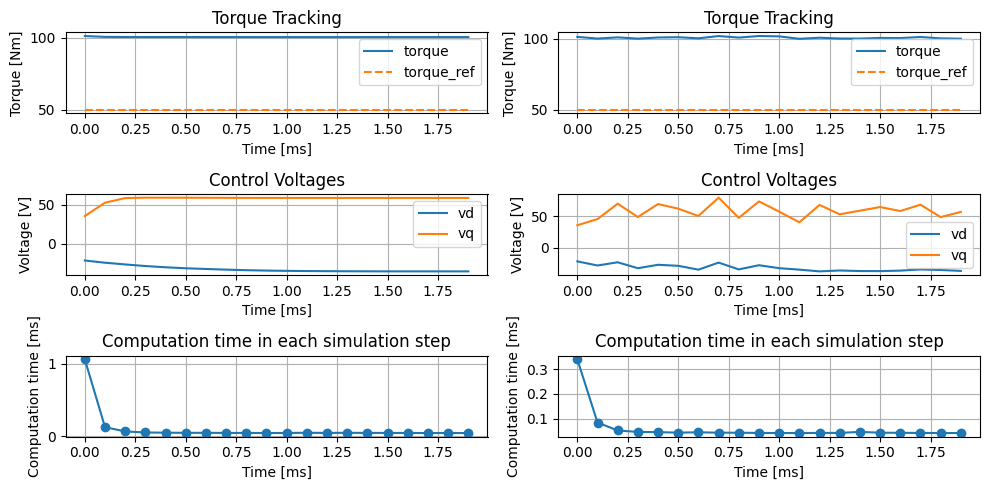

DDPG with noise in training


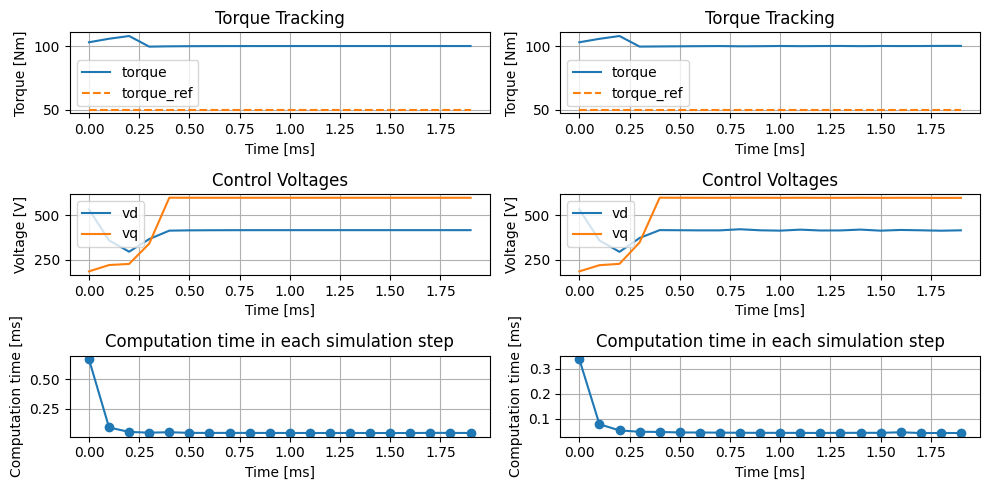

In [19]:
def run_DDPG_controller_sim(envs, ddpg, figsize=(10, 5), show=True):
    seed = 0

    # Load algorithm
    controller = ddpg
    # Run simulation and store data for table
    table_data = run_simulation(envs=envs, controller=controller, controller_type="RL", metrics=metrics, 
                                figsize=figsize, sim_steps=sim_plot_steps, plot=show)
    
    table = pd.DataFrame(table_data, index=["DDPG / env", "DDPG / noisy env"], columns=columns)
    table = table.fillna("")
    table = table.style \
    .format(precision=3, thousands=".", decimal=",") \
    .set_table_styles([
        {"selector": "th", "props": [("text-align", "center")]},
        {"selector": "td", "props": [("text-align", "center")]}
    ])
    
    if show:
        display(table)

    return table_data

print("DDPG without noise in training")
_ = run_DDPG_controller_sim([env, env_noisy], ddpg)
print("DDPG with noise in training")
_ = run_DDPG_controller_sim([env, env_noisy], ddpg_with_noise)

## PI Controller

In [20]:
# Interactive wrapper function
def run_pi_controller_sim(Kp, Ki, envs, figsize=(10, 5), show=True):
    Ts = sys_params["dt"]
    controller = PIController(Kp=Kp, Ki=Ki, Ts=Ts, umax=sys_params["vdc"]/2)
    table_data = run_simulation(envs=envs, controller=controller, controller_type="PI", metrics=metrics, 
                                figsize=figsize, sim_steps=sim_plot_steps, plot=show)
    
    table = pd.DataFrame(table_data, index=["PI Controller"], columns=columns)
    table = table.fillna("")
    table = table.style \
    .format(precision=3, thousands=".", decimal=",") \
    .set_table_styles([
        {"selector": "th", "props": [("text-align", "center")]},
        {"selector": "td", "props": [("text-align", "center")]}
    ])

    if show:
        display(table)

    return table_data

In [21]:
# Initial gains for controller
Kp = 3.9932
Ki = Kp*(1-0.8776)/sys_params["dt"]

# Create sliders 
Kp_slider = widgets.FloatSlider(value=Kp, min=0, max=20, step=0.1, description='Kp')
Ki_slider = widgets.FloatSlider(value=Ki, min=0, max=100_000, step=1, description='Ki')

# Connect widgets to function
ui = widgets.HBox([Kp_slider, Ki_slider])
out = widgets.interactive_output(
    run_pi_controller_sim, 
    {
        'Kp': Kp_slider, 
        'Ki': Ki_slider, 
        'envs': widgets.fixed(env_noisy),
        'figsize': widgets.fixed(figsize)
    }
)

display(ui, out)

Output()

## Group1: Model Predictive Control Implementation
**Added from pmsm_control_solution.ipynb**

For a explanation in detail check: [Model Predictive Control System Design and Implementation Using MATLAB](https://link.springer.com/book/10.1007/978-1-84882-331-0)

**Model Predictive Control (MPC)** is a control strategy that uses a model of the system to **predict future behavior** and **optimize control actions** at each time step.


**Key idea:**  
At every control step, MPC:
1. Predicts how the system will evolve over a future horizon using its model.  
2. Computes a sequence of control inputs that minimize a cost function (e.g., tracking error + control effort).  
3. Applies **only the first control input** from the sequence.  
4. Repeats the process at the next time step with updated measurements (receding horizon).


**Main components:**  
- **System model:** Describes how inputs affect future states.  
- **Cost function:** Balances tracking performance and control effort.  
- **Constraints:** Limitations on inputs or states (e.g., voltage, current, speed).  
- **Prediction horizon:** Number of future steps considered in the optimization.  


**Advantages:**  
- Handles **multi-variable** systems naturally.  
- Can explicitly **enforce constraints**.  
- Provides **optimal control actions** over time.


In short, MPC predicts the future and optimizes the next action to keep the system on track while respecting constraints. 

The cost function for this problem looks like:
$$
\min_u{\,(y_N-r)^TP(y_N-r) \,+\, \sum_{k=0}^{N-1}{(y_k-r)^TQ(y_k-r)} \,+\, \sum_{k=0}^{N}{\Delta u_k^TR\Delta u_k}}
$$
where $y$ is the output, $r$ is the reference, $\Delta u$ is the variation of the input, and $Q,P,R$ are weight matrices to balance the different goals.

<div style="text-align: center">
  <img src="./images/MPC_scheme_basic.svg" alt="Control Scheme" />
</div>

In [22]:
# Group1: Added from pmsm_control_solution.ipynb

# Interactive wrapper function
def run_mpc_controller_sim(Q, P, R, envs, figsize=(10, 5), show=True):
    controller = MPCController(env.unwrapped, Q, P, R)
    table_data = run_simulation(envs=envs, controller=controller, controller_type="MPC", metrics=metrics, 
                                figsize=figsize, sim_steps=sim_plot_steps, plot=show)

    table = pd.DataFrame(table_data, index=["MPC"], columns=columns)
    table = table.fillna("")
    table = table.style \
    .format(precision=3, thousands=".", decimal=",") \
    .set_table_styles([
        {"selector": "th", "props": [("text-align", "center")]},
        {"selector": "td", "props": [("text-align", "center")]}
    ])

    if show:
        display(table)
    
    return table_data

In [23]:
# Group1: Added from pmsm_control_solution.ipynb

# Initialize controller
Q = 100
P = 10
R = 1

# Create sliders
Q_slider = widgets.FloatSlider(value=Q, min=0, max=200, step=1, description='Q')  # y-r (reference tracking error)
P_slider = widgets.FloatSlider(value=P, min=0, max=2000, step=1, description='P') # y_N-r_N (steady-state reference tracking error)
R_slider = widgets.FloatSlider(value=R, min=0, max=200, step=1, description='R')  # Δu (input difference)

# Connect widgets to function
ui = widgets.HBox([Q_slider, P_slider, R_slider])
out = widgets.interactive_output(
    run_mpc_controller_sim, 
    {
        'Q': Q_slider, 
        'P': P_slider, 
        'R': R_slider, 
        'envs': widgets.fixed(env),
        'figsize': widgets.fixed(figsize)
    }
)
display(ui, out)

Output()

## Transfer Learning

In [24]:
new_ddpg_with_noise = DDPG(env_with_noise=True)
if train:
    new_ddpg_with_noise.load_model("DDPG")
    new_ddpg_with_noise_logs = new_ddpg_with_noise.train("DDPG_noise_TL")

Transfer Learning using DDPG trained with env


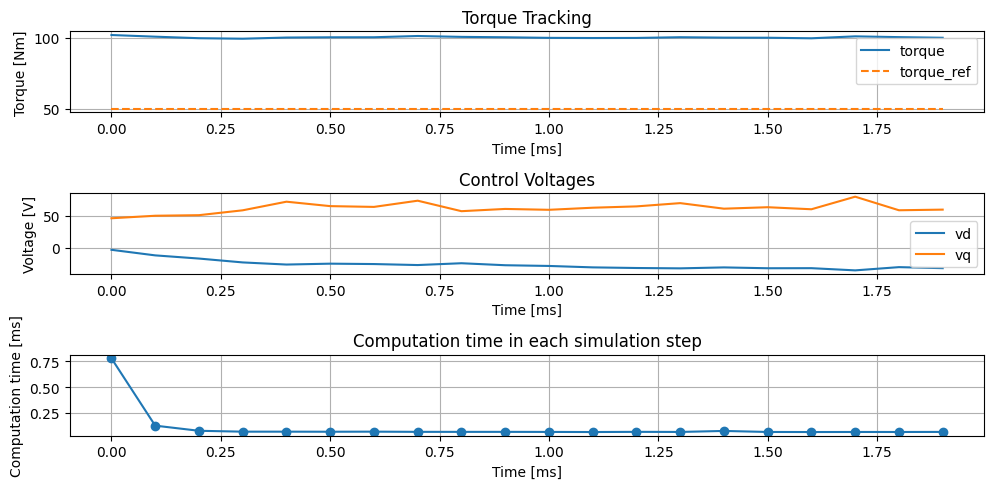

In [25]:
new_ddpg_with_noise.load_model("DDPG_noise_TL")
print("Transfer Learning using DDPG trained with env")
_ = run_DDPG_controller_sim([env_noisy], new_ddpg_with_noise)